In [11]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
from xgboost import XGBRegressor

In [12]:
# Configure Notebook
sns.set_theme()
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [13]:
# Cleans Data
def clean_data(df, remove_na = True):
    # Nan values changed as appropriate
    df.loc[df.LotFrontage.isna(), "LotFrontage"] = 0
    df.loc[df.Alley.isna(), "Alley"] = "None"
    df.loc[df.MasVnrType.isna(), "MasVnrType"] = "None"
    df.loc[df.MasVnrArea.isna(), "MasVnrArea"] = 0
    df.loc[df.BsmtFinType2.isna(), ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]] = "No Basement"
    df.loc[df.FireplaceQu.isna(), "FireplaceQu"] = "No Fireplace"
    df.loc[df.GarageType.isna(), ["GarageType", "GarageQual", "GarageFinish", "GarageCond"]] = "No Garage"
    df.loc[df.PoolQC.isna(), "PoolQC"] = "No Pool"
    df.loc[df.Fence.isna(), "Fence"] = "No Fence"
    df.loc[df.MiscFeature.isna(), "MiscFeature"] = "None"

    if remove_na: # Samples with remaining nan value for Electrical and BsmtExposure removed
        df = df[df.Electrical.notna()]
        df = df[df.BsmtExposure.notna()]
    
    # GarageYrBlt - kept as nan values
    
    # Wrangle other values
    df.MSSubClass = "Class " + df.MSSubClass.astype(str) # Converted to category
    return df

In [14]:
# Machine Learning Pipeline
def ml_pipepline(data_batches, param_grid, regressor,
                 cv = 5, measure = "rmse", n_jobs = -1,
                 plot = True, print_eval = True):
    
    best_measure = np.inf
    
    for batch in data_batches:
        x_train, x_test = df_X_batches_all_train[batch], df_X_batches_all_test[batch]
        x_train.columns,  x_test.columns = x_train.columns.map(str).str.replace(' ', ''), x_test.columns.map(str).str.replace(' ', '')
        y_train, y_test = df_Y_batches_all_train[batch], df_Y_batches_all_test[batch]
        
        grid_search = GridSearchCV(regressor, param_grid, cv = 5, n_jobs = n_jobs)
        grid_search.fit(x_train, y_train)
        
        # Train best Decision Tree model
        model = grid_search.best_estimator_.fit(x_train, y_train)
        
        # Test model
        y_pred = model.predict(x_test)
        mae = mean_absolute_error(np.exp(y_pred), np.exp(y_test))
        rmse = np.sqrt(mean_squared_error(np.exp(y_pred), np.exp(y_test)))
        
        # Model evaluation
        if print_eval:
            print(f"Batch {batch} | RMSE : {round(rmse/(10**3))},000 , MAE : {round(mae/(10**3))},000")

        # Update best model
        if ((measure == "rmse") & (rmse < best_measure)):
            best_measure = rmse
            best_batch = batch
            best_model = model
            y_pred_best = y_pred
            y_test_best = y_test

        if ((measure == "mae") & (mae < best_measure)):
            best_measure = mae
            best_batch = batch
            best_model = model
            y_pred_best = y_pred
            y_test_best = y_test


    if plot:
        x_plot, y_plot = np.exp(y_test_best)/1000, np.exp(y_pred_best)/1000
        plt.plot(x_plot, y_plot , '.')
        plt.plot([])
        plt.xlabel("Actual House Price ($K)"), plt.ylabel("Predicted House Price ($K)"), plt.title(f"Best data batch = {best_batch}");
        plt.plot()
        plt.show()
        
    return best_model, best_batch, best_measure


In [15]:
# Read data
df = pd.read_csv("/home/priyam-patel/projects/House PP/house-prices-advanced-regression-techniques/train.csv")
df = clean_data(df)

df_X = df.drop(["SalePrice", "Id"], axis = 1)
df_X["HouseAge"] = df_X.YrSold - df_X.YearBuilt
df_X["MoSold_label"] = "month" + df_X.MoSold.astype(str)

df_Y = df[["SalePrice"]]
df_Y.SalePrice = np.log(df_Y.SalePrice)

In [18]:
# Split data into test/train
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size = 0.3, random_state = 1)

# Split X data into numeric, non-numeric and dates
date_variables = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "MoSold", "YrSold"] 

def create_datasets_by_type(X_train, X_test):
    df_X_dates_train = X_train[date_variables]
    df_X_dates_test = X_test[date_variables]
    df_X_non_numeric_train = X_train[X_train.dtypes.index[X_train.dtypes == 'O']]
    df_X_non_numeric_test = X_test[X_test.dtypes.index[X_test.dtypes == 'O']]
    df_X_numeric_train = X_train[X_train.dtypes.index[X_train.dtypes != 'O']].drop(date_variables, axis = 1)
    df_X_numeric_test = X_test[X_test.dtypes.index[X_test.dtypes != 'O']].drop(date_variables, axis = 1)
    return df_X_dates_train, df_X_dates_test, df_X_non_numeric_train, df_X_non_numeric_test, df_X_numeric_train, df_X_numeric_test

df_X_dates_train, df_X_dates_test, df_X_non_numeric_train, df_X_non_numeric_test, df_X_numeric_train, df_X_numeric_test = create_datasets_by_type(X_train, X_test)

In [19]:
features_PCA = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "GrLivArea", "TotRmsAbvGrd", "OpenPorchSF"]
scaler = StandardScaler().fit(df_X_numeric_train[features_PCA])
df_X_numeric_train[features_PCA] = scaler.fit_transform(df_X_numeric_train[features_PCA])
df_X_numeric_test[features_PCA] = scaler.transform(df_X_numeric_test[features_PCA])

# Batch 1: Numeric
df_X_batch1_train = df_X_numeric_train
df_Y_batch1_train = y_train

df_X_batch1_test = df_X_numeric_test
df_Y_batch1_test = y_test

# Batch 2: Numeric w/ outliers removed
z_val = 2
lotArea_Z = df_X_numeric_train.LotArea.mean() + z_val * df_X_numeric_train.LotArea.std()
df_X_batch2_train = df_X_numeric_train.loc[df_X_numeric_train.LotArea < lotArea_Z]
df_Y_batch2_train = y_train.loc[df_X_numeric_train.LotArea < lotArea_Z]

df_X_batch2_test = df_X_numeric_test
df_Y_batch2_test = y_test

# Batch 3: Numeric w/ PCA, outliers removed
pca = PCA(n_components = 0.95)
df_X_numeric_train_noOutliers = df_X_numeric_train.loc[df_X_numeric_train.LotArea < lotArea_Z]
pca_fitted = pca.fit_transform(df_X_numeric_train_noOutliers[features_PCA])
df_X_batch3_train = pd.concat([pd.DataFrame(pca_fitted).reset_index(),
                               df_X_numeric_train_noOutliers.drop(features_PCA, axis = 1).reset_index()], axis = 1)
df_Y_batch3_train = y_train.loc[df_X_numeric_train.LotArea < lotArea_Z]

df_X_batch3_test = pd.concat([pd.DataFrame(pca.transform(df_X_numeric_test[features_PCA])).reset_index(), 
                              df_X_numeric_test.drop(features_PCA, axis = 1).reset_index()], axis = 1)
df_Y_batch3_test = y_test

# Batch 4: Numeric + hot-encoded non-numeric
encoder = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")
one_hot_encoded_train = encoder.fit_transform(df_X_non_numeric_train)
df_one_hot_encoded_train = pd.DataFrame(one_hot_encoded_train, columns = encoder.get_feature_names_out())
df_X_batch4_train = pd.concat([df_one_hot_encoded_train.reset_index(), df_X_numeric_train.reset_index()], axis = 1).drop('index', axis = 1)
df_Y_batch4_train = y_train

one_hot_encoded_test = encoder.transform(df_X_non_numeric_test) ### CHECK HERE
df_one_hot_encoded_test = pd.DataFrame(one_hot_encoded_test, columns = encoder.get_feature_names_out())
df_X_batch4_test = pd.concat([df_one_hot_encoded_test.reset_index(), df_X_numeric_test.reset_index()], axis = 1).drop('index', axis = 1)
df_Y_batch4_test = y_test

# Batch 5: Numeric + hot-encoded non-numeric w/ outliers removed
encoder = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")
one_hot_encoded = encoder.fit_transform(df_X_non_numeric_train)
df_one_hot_encoded = pd.DataFrame(one_hot_encoded, columns = encoder.get_feature_names_out())
df_X_batch5_train = pd.concat([df_one_hot_encoded.reset_index(), df_X_numeric_train.reset_index()], axis = 1)
df_X_batch5_train = df_X_batch5_train.loc[df_X_batch5_train.LotArea < lotArea_Z]
df_Y_batch5_train = y_train.loc[df_X_numeric_train.LotArea < lotArea_Z]

one_hot_encoded_test = encoder.transform(df_X_non_numeric_test)
df_one_hot_encoded_test = pd.DataFrame(one_hot_encoded_test, columns = encoder.get_feature_names_out())
df_X_batch5_test = pd.concat([df_one_hot_encoded_test.reset_index(), df_X_numeric_test.reset_index()], axis = 1)
df_Y_batch5_test = y_test

# Batch 6: Scaled Numeric + hot-encoded non-numeric
df_X_dates_train, df_X_dates_test, df_X_non_numeric_train, df_X_non_numeric_test, df_X_numeric_train, df_X_numeric_test = create_datasets_by_type(X_train, X_test)
scaler = StandardScaler().fit(df_X_numeric_train)
df_X_numeric_train = pd.DataFrame(scaler.fit_transform(df_X_numeric_train), columns = df_X_numeric_train.columns)
df_X_numeric_test = pd.DataFrame(scaler.transform(df_X_numeric_test), columns = df_X_numeric_test.columns)

encoder = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")
one_hot_encoded_train = encoder.fit_transform(df_X_non_numeric_train)
df_one_hot_encoded_train = pd.DataFrame(one_hot_encoded_train, columns = encoder.get_feature_names_out())
df_X_batch6_train = pd.concat([df_one_hot_encoded_train.reset_index(), df_X_numeric_train.reset_index()], axis = 1).drop('index', axis = 1)
df_Y_batch6_train = y_train

one_hot_encoded_test = encoder.transform(df_X_non_numeric_test)
df_one_hot_encoded_test = pd.DataFrame(one_hot_encoded_test, columns = encoder.get_feature_names_out())
df_X_batch6_test = pd.concat([df_one_hot_encoded_test.reset_index(), df_X_numeric_test.reset_index()], axis = 1).drop('index', axis = 1)
df_Y_batch6_test = y_test

# Batches Combined
df_X_batches_all_train = {1: df_X_batch1_train, 2: df_X_batch2_train, 3: df_X_batch3_train, 4: df_X_batch4_train, 5: df_X_batch5_train, 6: df_X_batch6_train}
df_Y_batches_all_train = {1: df_Y_batch1_train, 2: df_Y_batch2_train, 3: df_Y_batch3_train, 4: df_Y_batch4_train, 5: df_Y_batch5_train, 6: df_Y_batch6_train}

df_X_batches_all_test = {1: df_X_batch1_test, 2: df_X_batch2_test, 3: df_X_batch3_test, 4: df_X_batch4_test, 5: df_X_batch5_test, 6: df_X_batch6_test}
df_Y_batches_all_test = {1: df_Y_batch1_test, 2: df_Y_batch2_test, 3: df_Y_batch3_test, 4: df_Y_batch4_test, 5: df_Y_batch5_test, 6: df_Y_batch6_test}

In [20]:
models_all = {}
data_batches = [1, 2, 3, 4, 5, 6]

Batch 1 | RMSE : 110,000 , MAE : 22,000
Batch 2 | RMSE : 171,000 , MAE : 25,000
Batch 3 | RMSE : 140,000 , MAE : 23,000
Batch 4 | RMSE : 141,000 , MAE : 22,000


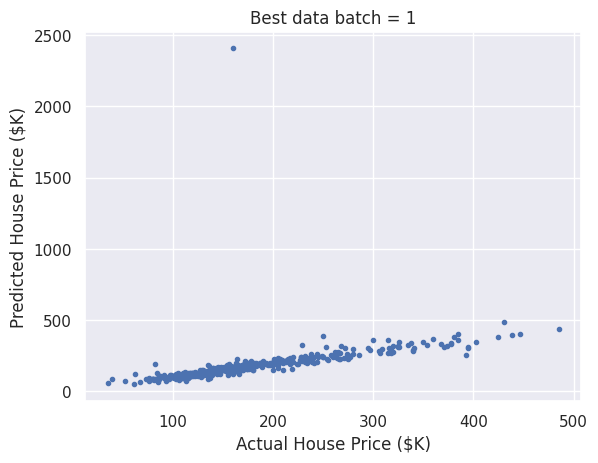

In [24]:
#Linear Regression
data_batches_linear = [1, 2, 3, 4]
param_grid = {}

regressor = LinearRegression()

best_model, best_batch, best_measure = ml_pipepline(data_batches_linear, param_grid, regressor, cv = 5)
models_all["linear"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 1 | RMSE : 116,000 , MAE : 22,000
Batch 2 | RMSE : 154,000 , MAE : 23,000
Batch 3 | RMSE : 138,000 , MAE : 22,000
Batch 4 | RMSE : 91,000 , MAE : 19,000
Batch 5 | RMSE : 126,000 , MAE : 20,000
Batch 6 | RMSE : 86,000 , MAE : 19,000


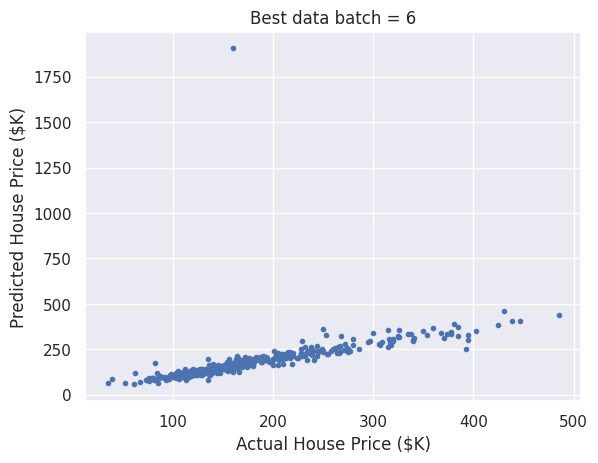

In [25]:
#ElasticNet Regression
param_grid = {"alpha": [0.1, 1, 10, 100], 
              "l1_ratio": np.arange(0,1.2,0.2)}

regressor = ElasticNet(max_iter = 10000, random_state = 1)

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = 5)
models_all["ElasticNet"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 1 | RMSE : 36,000 , MAE : 25,000
Batch 2 | RMSE : 40,000 , MAE : 26,000
Batch 3 | RMSE : 38,000 , MAE : 25,000
Batch 4 | RMSE : 38,000 , MAE : 25,000
Batch 5 | RMSE : 39,000 , MAE : 25,000
Batch 6 | RMSE : 38,000 , MAE : 25,000


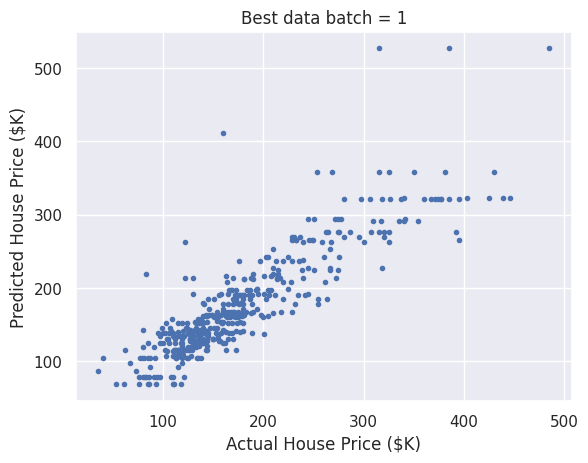

In [26]:
#Decision Tree
param_grid = {"max_depth": [5, 10, 50], 
              "max_features": ["sqrt", None],
              "min_samples_split" : [2, 5, 10],
              'min_samples_leaf': [2, 4, 10]}

regressor = DecisionTreeRegressor(random_state = 1)

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = 5)
models_all["DecisionTree"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 1 | RMSE : 28,000 , MAE : 18,000
Batch 2 | RMSE : 30,000 , MAE : 18,000
Batch 3 | RMSE : 28,000 , MAE : 18,000
Batch 4 | RMSE : 27,000 , MAE : 17,000
Batch 5 | RMSE : 30,000 , MAE : 17,000
Batch 6 | RMSE : 27,000 , MAE : 18,000


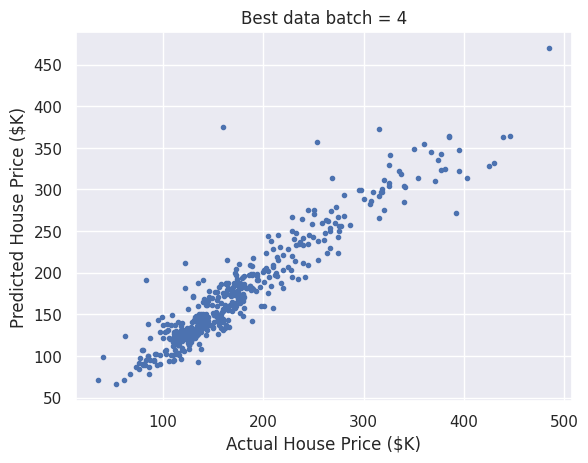

In [27]:
#Randon Forest
param_grid = {"n_estimators": [10, 50, 100],
              "max_depth": [5, 10, 50], 
              "max_features": ["sqrt", None],
              "min_samples_split" : [2, 5, 10],
              'min_samples_leaf': [2, 4, 10]}

regressor = RandomForestRegressor()

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = 5)
models_all["RandomForest"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 1 | RMSE : 54,000 , MAE : 35,000
Batch 2 | RMSE : 105,000 , MAE : 33,000
Batch 3 | RMSE : 163,000 , MAE : 58,000
Batch 4 | RMSE : 78,000 , MAE : 38,000
Batch 5 | RMSE : 102,000 , MAE : 46,000
Batch 6 | RMSE : 22,000 , MAE : 14,000


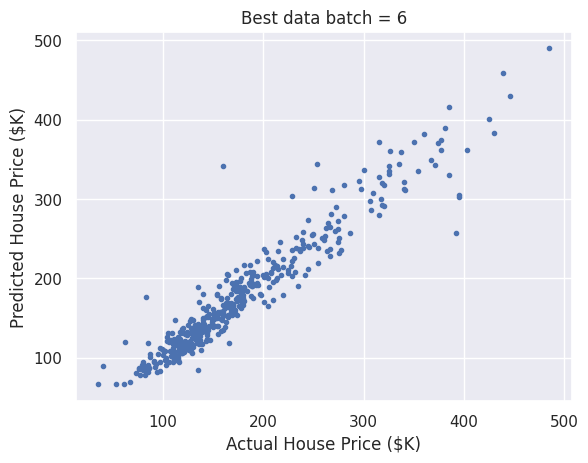

In [28]:
#Support Vector Regression
param_grid = {"gamma": [0.1, 1.0, 10, 100, "auto"],
              "C": [0.1, 1.0, 10, 100], 
              "kernel": ["linear", "poly", "rbf", "sigmoid"],
              'epsilon': [0.1, 0.5, 1.0, 2.0]}

regressor = SVR(max_iter = 10000)

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = 5)
models_all["SVR"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 1 | RMSE : 28,000 , MAE : 17,000
Batch 4 | RMSE : 25,000 , MAE : 16,000
Batch 6 | RMSE : 26,000 , MAE : 16,000


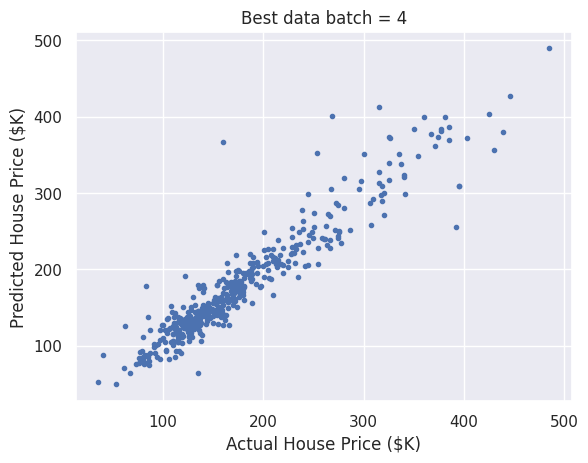

In [29]:
#Gradient Boosting
data_batches = [1, 4, 6]

param_grid = {"learning_rate": [0.01, 0.1, 1, 10], 
              "n_estimators": [10, 20, 100, 200],
              "subsample" : [0.2, 0.4, 0.8, 1],
              'min_samples_leaf': [2, 4, 10], 
              'max_depth': [3, 5, 10]}

regressor = GradientBoostingRegressor(random_state = 1)

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = 5)
models_all["GradientBoost"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 1 | RMSE : 25,000 , MAE : 17,000
Batch 4 | RMSE : 23,000 , MAE : 16,000
Batch 6 | RMSE : 23,000 , MAE : 16,000


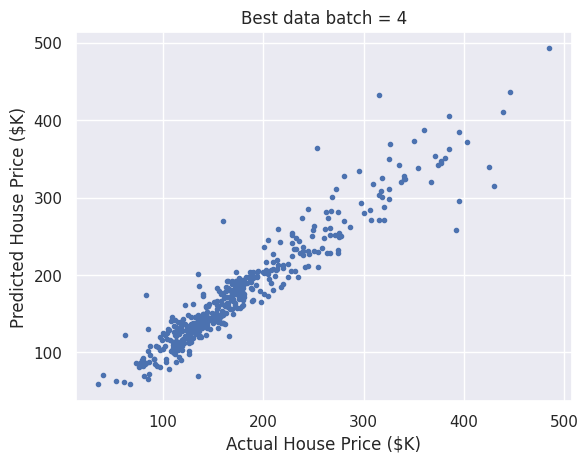

In [30]:
#XGBoost
data_batches = [1, 4, 6]

param_grid = {'max_depth': [2, 3, 5, 10, 20],
              'eta': [0.01, 0.1, 1, 10],
              'subsample': [0, 0.2, 0.5, 0.8, 1.0],
              'colsample_bytree': [0, 0.2, 0.5, 0.8, 1.0]}

regressor = XGBRegressor()

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = 5)
models_all["XGBoost"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

In [31]:
models_tuned = {}
cv = 10

In [32]:
# Try 1
svr_1 = models_all["SVR"]["best_model"]
print(f"SVR Try 1: gamma = {svr_1.gamma}, C = {svr_1.C}, kernel = {svr_1.kernel}, epsilon = {svr_1.epsilon}")
models_tuned["SVR-1"] = models_all["SVR"]

SVR Try 1: gamma = auto, C = 1.0, kernel = rbf, epsilon = 0.1


In [33]:
data_batches = [6]

param_grid = {"gamma": ["auto"],
              "C": [0.5, 0.8, 1.0, 2, 5], 
              "kernel": ["rbf"],
              'epsilon': [0.05, 0.08, 0.1, 0.2, 0.3]}

regressor = SVR(max_iter = 10000)

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = cv, plot = False)

print(f"SVR Try 2: gamma = {best_model.gamma}, C = {best_model.C}, kernel = {best_model.kernel}, epsilon = {best_model.epsilon}")
models_tuned["SVR-2"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 6 | RMSE : 22,000 , MAE : 14,000
SVR Try 2: gamma = auto, C = 1.0, kernel = rbf, epsilon = 0.05


In [34]:
# Try 1
best_model = models_all["GradientBoost"]["best_model"]
print(f"GB Try 1: learning_rate = {best_model.learning_rate}, n_estimators = {best_model.n_estimators}, subsample = {best_model.subsample}, min_samples_leaf = {best_model.min_samples_leaf}, max_depth = {best_model.max_depth}")
models_tuned["GradientBoost-1"] = models_all["GradientBoost"]

GB Try 1: learning_rate = 0.1, n_estimators = 200, subsample = 0.4, min_samples_leaf = 10, max_depth = 3


In [35]:
#Try 2
data_batches = [4]

param_grid = {"learning_rate": [0.1], 
              "n_estimators": [200, 400, 600],
              "subsample" : [0.3, 0.4, 0.5, 0.6],
              'min_samples_leaf': [8, 10, 12, 15], 
              'max_depth': [1, 2, 3, 4]}

regressor = GradientBoostingRegressor(random_state = 1)

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = cv, plot = False)

print(f"GB Try 2: learning_rate = {best_model.learning_rate}, n_estimators = {best_model.n_estimators}, subsample = {best_model.subsample}, min_samples_leaf = {best_model.min_samples_leaf}, max_depth = {best_model.max_depth}")
models_tuned["GradientBoost-2"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 4 | RMSE : 25,000 , MAE : 16,000
GB Try 2: learning_rate = 0.1, n_estimators = 200, subsample = 0.4, min_samples_leaf = 10, max_depth = 3


In [36]:
# Try 3
data_batches = [4]

param_grid = {"learning_rate": [0.1], 
              "n_estimators": [300, 400, 500],
              "subsample" : [0.45, 0.5, 0.55],
              'min_samples_leaf': [11, 12, 13, 14], 
              'max_depth': [1, 2, 3]}

regressor = GradientBoostingRegressor(random_state = 1)

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = cv, plot = False)

print(f"GB Try 3: learning_rate = {best_model.learning_rate}, n_estimators = {best_model.n_estimators}, subsample = {best_model.subsample}, min_samples_leaf = {best_model.min_samples_leaf}, max_depth = {best_model.max_depth}")
models_tuned["GradientBoost-3"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 4 | RMSE : 24,000 , MAE : 15,000
GB Try 3: learning_rate = 0.1, n_estimators = 300, subsample = 0.55, min_samples_leaf = 13, max_depth = 3


In [37]:
#Randon Forest
# Try 1
rf_model_1 = models_all["RandomForest"]["best_model"]
print(f"RF Try 1: n_estimators = {rf_model_1.n_estimators}, max_depth = {rf_model_1.max_depth}, max_features = {rf_model_1.max_features}, min_samples_split = {rf_model_1.min_samples_split}, min_samples_leaf = {rf_model_1.min_samples_leaf}")
models_tuned["RandomForest-1"] = models_all["RandomForest"]

RF Try 1: n_estimators = 100, max_depth = 10, max_features = None, min_samples_split = 5, min_samples_leaf = 2


In [38]:
# Try 2
data_batches = [4, 6]
param_grid = {"n_estimators": [30, 40, 50, 60, 70],
              "max_depth": [25, 50, 75, 100], 
              "max_features": [None],
              "min_samples_split" : [1, 2, 4],
              'min_samples_leaf': [1, 2, 3]}

regressor = RandomForestRegressor(random_state = 1)

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = cv, plot = False)

print(f"RF Try 2: n_estimators = {best_model.n_estimators}, max_depth = {best_model.max_depth}, max_features = {best_model.max_features}, min_samples_split = {best_model.min_samples_split}, min_samples_leaf = {best_model.min_samples_leaf}")
models_tuned["RandomForest-2"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 4 | RMSE : 26,000 , MAE : 17,000
Batch 6 | RMSE : 26,000 , MAE : 17,000
RF Try 2: n_estimators = 70, max_depth = 50, max_features = None, min_samples_split = 2, min_samples_leaf = 1


In [39]:
# Try 3
data_batches = [6]
param_grid = {"n_estimators": [70, 75, 80, 90],
              "max_depth": [30, 40, 56, 50, 55, 60, 70], 
              "max_features": [None],
              "min_samples_split" : [2, 3],
              'min_samples_leaf': [1, 2]}

regressor = RandomForestRegressor(random_state = 1)

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = cv, plot = False)

print(f"RF Try 3: n_estimators = {best_model.n_estimators}, max_depth = {best_model.max_depth}, max_features = {best_model.max_features}, min_samples_split = {best_model.min_samples_split}, min_samples_leaf = {best_model.min_samples_leaf}")
models_tuned["RandomForest-3"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 6 | RMSE : 26,000 , MAE : 17,000
RF Try 3: n_estimators = 80, max_depth = 30, max_features = None, min_samples_split = 2, min_samples_leaf = 1


In [40]:
#XGBoost
# Try 1
best_model = models_all["XGBoost"]["best_model"]
print(f"XGBoost Try 1: max_depth = {best_model.get_params()['max_depth']}, eta = {best_model.get_params()['eta']}, subsample = {best_model.get_params()['subsample']}, colsample_bytree = {best_model.get_params()['colsample_bytree']}")
models_tuned["XGBoost-1"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

XGBoost Try 1: max_depth = 5, eta = 0.1, subsample = 0.5, colsample_bytree = 0.5


In [41]:
data_batches = [1, 4]

param_grid = {'max_depth': [2, 3, 4],
              'eta': [0.01, 0.1],
              'subsample': [0.3, 0.4, 0.5, 0.6, 0.7],
              'colsample_bytree': [0.9, 1.0]}

regressor = XGBRegressor()

best_model, best_batch, best_measure = ml_pipepline(data_batches, param_grid, regressor, cv = cv, plot = False)

print(f"XGBoost Try 2: max_depth = {best_model.get_params()['max_depth']}, eta = {best_model.get_params()['eta']}, subsample = {best_model.get_params()['subsample']}, colsample_bytree = {best_model.get_params()['colsample_bytree']}")
models_tuned["XGBoost-2"] = {"best_model" : best_model, "best_batch" : best_batch, "best_measure": best_measure}

Batch 1 | RMSE : 25,000 , MAE : 17,000
Batch 4 | RMSE : 24,000 , MAE : 16,000
XGBoost Try 2: max_depth = 4, eta = 0.1, subsample = 0.5, colsample_bytree = 0.9


In [42]:
#SVR Iteration 1 is best performing
models_tuned_summary = pd.DataFrame.from_dict(models_tuned, orient = 'index')
models_tuned_summary.best_measure = round(models_tuned_summary.best_measure/1000)
models_tuned_summary.sort_values('best_measure')

,best_model,best_batch,best_measure
SVR-1,"SVR(gamma='auto', max_iter=10000)",6,22.0
SVR-2,"SVR(epsilon=0.05, gamma='auto', max_iter=10000)",6,22.0
GradientBoost-3,([DecisionTreeRegressor(criterion='friedman_ms...,4,24.0
XGBoost-2,"XGBRegressor(base_score=None, booster=None, ca...",4,24.0
GradientBoost-2,([DecisionTreeRegressor(criterion='friedman_ms...,4,25.0
GradientBoost-1,([DecisionTreeRegressor(criterion='friedman_ms...,4,25.0
RandomForest-3,"(DecisionTreeRegressor(max_depth=30, random_st...",6,26.0
RandomForest-2,"(DecisionTreeRegressor(max_depth=50, random_st...",6,26.0
XGBoost-1,"XGBRegressor(base_score=None, booster=None, ca...",6,26.0
RandomForest-1,"(DecisionTreeRegressor(max_depth=10, min_sampl...",4,27.0


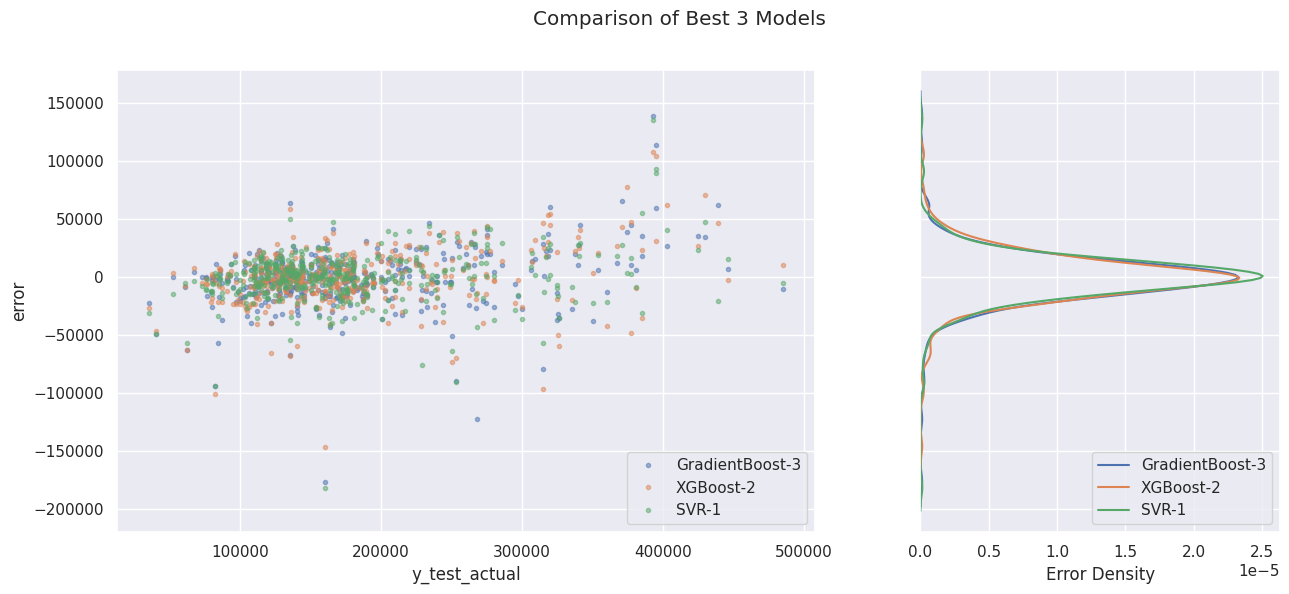

In [43]:
models_top3 = ['GradientBoost-3', 'XGBoost-2', 'SVR-1']

fig1, [ax1, ax2] = plt.subplots(1, 2, figsize = (15, 6), sharey = 'all', width_ratios = [0.66, 0.34])

for i, model_name in enumerate(models_top3):
    model = models_tuned[model_name]["best_model"]
    data_batch_best = models_tuned[model_name]["best_batch"]
    x_train, x_test = df_X_batches_all_train[data_batch_best], df_X_batches_all_test[data_batch_best]
    x_train.columns,  x_test.columns = x_train.columns.map(str).str.replace(' ', ''), x_test.columns.map(str).str.replace(' ', '')
    y_train, y_test = df_Y_batches_all_train[data_batch_best], df_Y_batches_all_test[data_batch_best]
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_accuracy = np.exp(y_test)
    model_accuracy["pred"] = np.exp(y_pred)
    model_accuracy["error"] = model_accuracy.SalePrice - model_accuracy.pred
    ax1.plot(model_accuracy.SalePrice, model_accuracy.error, '.', label = model_name, alpha = 0.5)
    sns.kdeplot(y = model_accuracy.error, label = model_name, ax = ax2)

ax1.legend(loc = 'lower right'), ax2.legend(loc = 'lower right')
ax1.set_xlabel('y_test_actual'), ax1.set_ylabel('error')
ax2.set_xlabel('Error Density')
plt.suptitle('Comparison of Best 3 Models');

In [44]:
final_best_model = models_tuned['SVR-1']['best_model']
final_best_model

,kernel,'rbf'
,degree,3
,gamma,'auto'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,10000


In [45]:
# Load previous train data
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size = 0.3, random_state = 1)
date_variables = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "MoSold", "YrSold"] 
df_X_dates_train = X_train[date_variables]
df_X_non_numeric_train = X_train[X_train.dtypes.index[X_train.dtypes == 'O']]
df_X_numeric_train = X_train[X_train.dtypes.index[X_train.dtypes != 'O']].drop(date_variables, axis = 1)

# Fit scaler
features_PCA = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "GrLivArea", "TotRmsAbvGrd", "OpenPorchSF"]
scaler_batch4 = StandardScaler().fit(df_X_numeric_train[features_PCA])
scaler_batch6 = StandardScaler().fit(df_X_numeric_train)

# Fit encoder
encoder = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")
one_hot_encoded_train = encoder.fit_transform(df_X_non_numeric_train)

In [47]:
# Read and clean test data
df_test_raw = pd.read_csv("/home/priyam-patel/projects/House PP/house-prices-advanced-regression-techniques/test.csv")

df_test = df_test_raw.copy()
df_test = clean_data(df_test, remove_na = False)

# Add new features
df_test = df_test.drop(["Id"], axis = 1)
df_test["HouseAge"] = df_test.YrSold - df_test.YearBuilt
df_test["MoSold_label"] = "month" + df_test.MoSold.astype(str)

# Split X data into numeric, non-numeric and dates
date_variables = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "MoSold", "YrSold"] 
df_X_dates_test_final = df_test[date_variables]
df_X_non_numeric_test_final = df_test[df_test.dtypes.index[df_test.dtypes == 'O']]
df_X_numeric_test_final = df_test[df_test.dtypes.index[df_test.dtypes != 'O']].drop(date_variables, axis = 1)

# Scale values
#df_X_numeric_test_final[features_PCA] = scaler_batch4.transform(df_X_numeric_test_final[features_PCA]) # For batch 4
df_X_numeric_test_final = pd.DataFrame(scaler_batch6.transform(df_X_numeric_test_final), columns = df_X_numeric_test_final.columns) # For batch 6

# Configure encoder for hot-encoding
one_hot_encoded_test_final = encoder.transform(df_X_non_numeric_test_final)
df_one_hot_encoded_test_final = pd.DataFrame(one_hot_encoded_test_final, columns = encoder.get_feature_names_out())
df_X_test = pd.concat([df_one_hot_encoded_test_final.reset_index(), df_X_numeric_test_final.reset_index()], axis = 1).drop('index', axis = 1)

# Remove spaces from feature names
df_X_test.columns = df_X_test.columns.map(str).str.replace(' ', '')

In [48]:
# The test dataset contains nan-values
df_check = df_X_test
print(f"\nData Shape: {df_check.shape}")

df_feature_counts = pd.DataFrame(df_check.count()).reset_index().rename({"index": "feature", 0: "counts"}, axis = 1).sort_values("counts")
print('\nFeatures with Nan values:\n', df_feature_counts.loc[df_feature_counts.counts < len(df_check)], '\n')
nan_features = np.array(df_feature_counts.loc[df_feature_counts.counts < len(df_check)]["feature"])

# Fill nan-values (replacement values as per best judgement and analysis of patterns in EDA)
row659_replace = [0, 0, df_X_test.iloc[660]["1stFlrSF"], 0, 0, df_X_test.iloc[660]["GarageCars"], df_X_test.iloc[660]["GarageArea"], 0]
for i, nan_feature in enumerate(nan_features):
    df_X_test.loc[660, nan_feature] = row659_replace[i]

df_X_test.loc[728, "BsmtFullBath"], df_X_test.loc[728, "BsmtHalfBath"] = 0, 0
	
df_X_test.loc[1116, "GarageArea"] = df_X_test.GarageArea.mean()
df_X_test.loc[1116, "GarageCars"]  = df_X_test.GarageCars.mode()[0]

# Post clean
print("\nPost Clean")
df_feature_counts = pd.DataFrame(df_X_test.count()).reset_index().rename({"index": "feature", 0: "counts"}, axis = 1).sort_values("counts")
print('\nFeatures with Nan values:\n', df_feature_counts.loc[df_feature_counts.counts < len(df_X_test)], '\n')


Data Shape: (1459, 314)

Features with Nan values:
           feature  counts
297  BsmtHalfBath    1457
296  BsmtFullBath    1457
305    GarageArea    1458
288    BsmtFinSF1    1458
290     BsmtUnfSF    1458
289    BsmtFinSF2    1458
291   TotalBsmtSF    1458
304    GarageCars    1458 


Post Clean

Features with Nan values:
 Empty DataFrame
Columns: [feature, counts]
Index: [] 



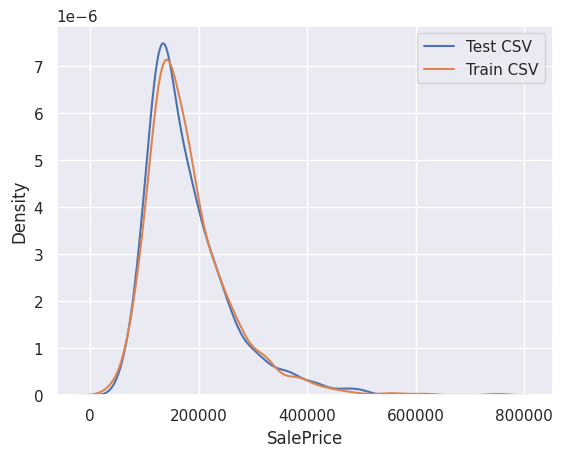

In [51]:
save_dir = "/home/priyam-patel/projects/House PP/house-prices-advanced-regression-techniques/results"

# Final prediction
final_predictions = np.exp(final_best_model.predict(df_X_test))

# Save result
df_test_save = pd.DataFrame({"Id":np.array(df_test_raw.Id), 
                            "SalePrice": final_predictions}) 
df_test_save.to_csv(save_dir + "submission.csv", index = False)

# Plot test predicted distribution vs train distribution
sns.kdeplot(final_predictions, label = "Test CSV")
sns.kdeplot(np.exp(df_Y.SalePrice), label = "Train CSV");
plt.legend()


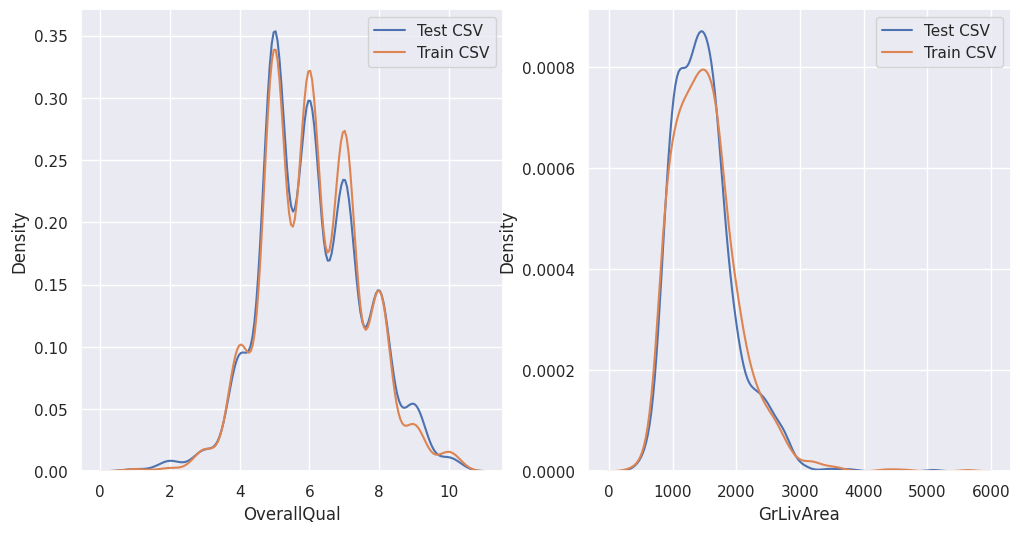

In [52]:
plt.subplots(1,2, figsize = (12, 6))

plt.subplot(1,2,1)
sns.kdeplot(df_test.OverallQual, label = "Test CSV")
sns.kdeplot(df_X.OverallQual, label = "Train CSV")
plt.legend()

plt.subplot(1,2,2)
sns.kdeplot(df_test.GrLivArea, label = "Test CSV")
sns.kdeplot(df_X.GrLivArea, label = "Train CSV")
plt.legend()